# Distance Plot
Notebook that generates a box-and-whisker plot for a given dataset.

### Configure Paths
In `MARIAM/data/` each folder is a *dataset*. Each dataset consists of a subfolder of trials for each controller type:
- `<MM-DD>_p_experiments/`: Data from position controller trials.
- `<MM-DD>_a_experiments/`: Data from admittance controller trials.
- `<MM-DD>_dp_experiments/`: Data from dynamic parameterization controller trials. 

Each trial folder consists of the following files:
- `monica_admittance_data.csv`: Admittance and manipulator data for Monica.
- `ross_admittance_data.csv`: Admittance and manipulator data for Ross.
- `trajectory_data.csv`: Locations and orientations of the payload, Monica, and Ross.

In [144]:
# Dataset path
dataset_name = '08-30_dataset'
dataset_path = f'../../data/{dataset_name}/'

# Controller type paths
dp_experiments_path = f'{dataset_path}08-30_dp_experiments/'
a_experiments_path = f'{dataset_path}08-30_a_experiments/'
p_experiments_path = f'{dataset_path}08-30_p_experiments/'

### Create Data Structure
All csv data across all trials will be organized in a singular data structure with the following format:
```python
data = {
    'p': {  # position controller
        'trial_01': {
            'trajectory': DataFrame,
            'monica_admittance': DataFrame, 
            'ross_admittance': DataFrame
        },
        'trial_02': { ... },
        ...
    },
    'a': { ... },  # admittance controller  
    'dp': { ... }  # dynamic parameterization controller
}
```

In [145]:
import pandas as pd
import os
import re
from pathlib import Path

def load_experiment_data(dataset_path):
    """
    Load all robotic experiment data without preprocessing.
    
    Args:
        dataset_path: Path to the main dataset folder (e.g., '../../data/08-30_dataset/')
    
    Returns:
        dict: Nested dictionary with structure data[controller][trial_num][file_type]
    """
    
    data = {}
    date_prefix = Path(dataset_path).name.split('_')[0]
    
    # File naming conventions by controller type
    file_mappings = {
        'p': {'monica': 'monica_position_data.csv', 'ross': 'ross_position_data.csv'},
        'a': {'monica': 'monica_admittance_data.csv', 'ross': 'ross_admittance_data.csv'},
        'dp': {'monica': 'monica_admittance_data.csv', 'ross': 'ross_admittance_data.csv'}
    }
    
    for controller in ['p', 'a', 'dp']:
        controller_path = os.path.join(dataset_path, f"{date_prefix}_{controller}_experiments")
        
        if not os.path.exists(controller_path):
            print(f"Warning: Path {controller_path} does not exist.")
            continue
            
        print(f"Loading {controller} controller data...")
        data[controller] = {}
        
        # Process all trial folders
        trial_folders = [f for f in os.listdir(controller_path) 
                        if os.path.isdir(os.path.join(controller_path, f)) and 'trial' in f]
        
        for trial_folder in sorted(trial_folders):
            trial_match = re.search(r'trial_(\d+)', trial_folder)
            if not trial_match:
                continue
                
            trial_num = trial_match.group(1)
            trial_path = os.path.join(controller_path, trial_folder)
            
            # Load trajectory data
            trajectory_file = os.path.join(trial_path, 'trajectory_data.csv')
            if not os.path.exists(trajectory_file):
                print(f"  Warning: trajectory_data.csv not found in trial {trial_num}")
                continue
            
            try:
                data[controller][trial_num] = {
                    'trajectory': pd.read_csv(trajectory_file)
                }
                
                # Load monica and ross data files
                for robot, filename in file_mappings[controller].items():
                    file_path = os.path.join(trial_path, filename)
                    if os.path.exists(file_path):
                        try:
                            data[controller][trial_num][f"{robot}_{controller}"] = pd.read_csv(file_path)
                        except Exception as e:
                            print(f"    Error loading {filename} in trial {trial_num}: {e}")
                    else:
                        print(f"    Warning: {filename} not found in trial {trial_num}")
                
            except Exception as e:
                print(f"  Error loading trial {trial_num}: {e}")
    
    # Summary
    print("\n" + "="*40)
    print("LOADING SUMMARY")
    print("="*40)
    total_trials = 0
    for controller in data:
        trial_count = len(data[controller])
        total_trials += trial_count
        print(f"{controller.upper()}: {trial_count} trials")
    print(f"Total: {total_trials} trials")
    
    return data
    

data = load_experiment_data(dataset_path=dataset_path)

Loading p controller data...
    Error loading ross_position_data.csv in trial 07: No columns to parse from file
    Error loading ross_position_data.csv in trial 20: No columns to parse from file
    Error loading ross_position_data.csv in trial 22: No columns to parse from file
Loading a controller data...
    Error loading ross_admittance_data.csv in trial 24: No columns to parse from file
Loading dp controller data...

LOADING SUMMARY
P: 20 trials
A: 20 trials
DP: 18 trials
Total: 58 trials


### Data Pre-Processing
Each The monica and ross CSV files for each trial will be cropped to the start and end times of the `trajectory_data.csv` file.

In [146]:
def crop_experiment_data(data):
    """
    Crop all non-trajectory data to match trajectory time bounds.
    
    Args:
        data: Data structure from load_experiment_data()
    
    Returns:
        dict: Same structure with cropped data
    """
    
    cropped_data = {}
    
    for controller in data:
        print(f"Cropping {controller} controller data...")
        cropped_data[controller] = {}
        
        for trial_num in data[controller]:
            trial_data = data[controller][trial_num]
            
            # Get time bounds from trajectory data
            trajectory_df = trial_data['trajectory']
            start_time = trajectory_df['ros_time_ns'].min()
            end_time = trajectory_df['ros_time_ns'].max()
            
            # Initialize with trajectory data (no cropping needed)
            cropped_data[controller][trial_num] = {
                'trajectory': trajectory_df.copy()
            }
            
            # Crop all other data files
            for data_type, df in trial_data.items():
                if data_type == 'trajectory':
                    continue
                    
                if 'ros_time_ns' not in df.columns:
                    print(f"    Warning: ros_time_ns column not found in {data_type}, trial {trial_num}")
                    cropped_data[controller][trial_num][data_type] = df.copy()
                    continue
                
                # Crop to trajectory time range
                original_length = len(df)
                cropped_df = df[(df['ros_time_ns'] >= start_time) & (df['ros_time_ns'] <= end_time)].copy()
                
                # Check coverage and warn if incomplete
                df_start, df_end = df['ros_time_ns'].min(), df['ros_time_ns'].max()
                if df_start > start_time or df_end < end_time:
                    print(f"    Warning: {data_type} trial {trial_num} doesn't fully cover trajectory time range")
                
                # print(f"    {data_type} trial {trial_num}: {original_length} -> {len(cropped_df)} rows")
                cropped_data[controller][trial_num][data_type] = cropped_df
    
    print("\nCropping complete!")
    return cropped_data

processed_data = crop_experiment_data(data=data)

Cropping p controller data...
Cropping a controller data...
Cropping dp controller data...

Cropping complete!


### Calculate Distance Travelled
The *distance traveled* is the distance the payload traveled before it was dropped. The time the payload is dropped is signaled by force value dropping below 0.5 for both robots. The total distance is calculated by summing the Euclidian distance from one time step to the next for each time step.

In [147]:
import numpy as np

def calculate_distance_traveled(data):
    """
    Calculate distance traveled by payload for each trial before force drops below 0.5.
    
    Args:
        data: Data structure from load_experiment_data() or crop_experiment_data()
    
    Returns:
        dict: {controller: [distances]} where distances is list of distances for each trial
    """
    
    distance_results = {}
    
    for controller in data:
        print(f"Processing {controller} controller...")
        distances = []
        
        for trial_num in sorted(data[controller].keys()):
            trial_data = data[controller][trial_num]
            
            try:
                # Get data
                trajectory_df = trial_data['trajectory']
                monica_df = trial_data[f'monica_{controller}']
                ross_df = trial_data[f'ross_{controller}']
                
                # Find earliest time force < 0.5 for each robot
                monica_low_mask = monica_df['force'] < 0.001
                if monica_low_mask.any():
                    monica_low_force_time = monica_df[monica_low_mask]['ros_time_ns'].min()
                else:
                    monica_low_force_time = monica_df['ros_time_ns'].max()
                
                ross_low_mask = ross_df['force'] < 0.001
                if ross_low_mask.any():
                    ross_low_force_time = ross_df[ross_low_mask]['ros_time_ns'].min()
                else:
                    ross_low_force_time = ross_df['ros_time_ns'].max()
                
                # Take the larger timestamp
                low_force_time = max(monica_low_force_time, ross_low_force_time)
                
                # Filter trajectory data up to low_force_time
                filtered_trajectory = trajectory_df[trajectory_df['ros_time_ns'] <= low_force_time]
                
                # Calculate total distance
                payload_distances = np.sqrt(
                    np.diff(filtered_trajectory['act_payload_x'])**2 + 
                    np.diff(filtered_trajectory['act_payload_y'])**2
                )
                total_distance = min(np.sum(payload_distances), 2.20)
                
                distances.append(total_distance)
                print(f"  Trial {trial_num}: {total_distance:.3f}")
                
            except Exception as e:
                print(f"  Error in trial {trial_num}: {e}")
        
        distance_results[controller] = distances
    
    return distance_results

# Try start to finish distance instead?
distance_results = calculate_distance_traveled(data=processed_data)

# Print all distances
# print("Distances traveled for debugging:")
# for controller, distances in distance_results.items():
#     for distance in distances:
#         print(f"  {controller} controller distance: {distance:.3f}")

Processing p controller...
  Trial 01: 0.079
  Trial 02: 0.044
  Trial 03: 0.089
  Trial 04: 0.084
  Trial 05: 0.135
  Trial 06: 0.141
  Error in trial 07: 'ross_p'
  Trial 08: 0.076
  Trial 09: 0.133
  Trial 10: 0.091
  Trial 16: 0.159
  Error in trial 17: 'force'
  Trial 18: 0.176
  Trial 19: 0.144
  Error in trial 20: 'ross_p'
  Trial 21: 0.226
  Error in trial 22: 'ross_p'
  Trial 23: 0.213
  Error in trial 24: 'force'
  Trial 25: 0.209
Processing a controller...
  Trial 01: 1.716
  Trial 02: 2.200
  Trial 03: 2.200
  Trial 04: 0.165
  Trial 05: 2.200
  Trial 06: 1.934
  Trial 07: 0.171
  Trial 08: 1.975
  Trial 09: 0.251
  Trial 10: 2.200
  Trial 16: 0.215
  Trial 17: 0.214
  Trial 18: 2.136
  Trial 19: 0.206
  Trial 20: 0.165
  Trial 21: 0.187
  Trial 22: 0.246
  Trial 23: 0.207
  Error in trial 24: 'ross_a'
  Trial 25: 0.235
Processing dp controller...
  Trial 01: 2.200
  Trial 02: 2.200
  Trial 03: 2.200
  Trial 04: 2.200
  Trial 05: 2.200
  Trial 06: 2.200
  Trial 07: 2.200
  

### Success Rate
A hard-coded array of success rates. Trial succes is categorized in the following way:
- `perfect`: The payload reaches the goal with no hiccups.
- `faulty`: The payload reaches the goal but the payload was not held stably.
- `failed`: The payload is dropped before the goal.

In [148]:
success_counts = {
    'p': { 'perfect': 0, 'faulty': 0, 'failed': 20 },
    'a': { 'perfect': 1, 'faulty': 4, 'failed': 15 },
    'dp': { 'perfect': 18, 'faulty': 0, 'failed': 0 }
}

# Calculate success rates using counts
success_rates = {
    controller: {
        'perfect': count['perfect'] / sum(count.values()) if sum(count.values()) > 0 else 0,
        'faulty': count['faulty'] / sum(count.values()) if sum(count.values()) > 0 else 0,
        'failed': count['failed'] / sum(count.values()) if sum(count.values()) > 0 else 0
    }
    for controller, count in success_counts.items()
}
success_rates

{'p': {'perfect': 0.0, 'faulty': 0.0, 'failed': 1.0},
 'a': {'perfect': 0.05, 'faulty': 0.2, 'failed': 0.75},
 'dp': {'perfect': 1.0, 'faulty': 0.0, 'failed': 0.0}}

## Plots
This section uses data gathered previously to make the following plots:
- Distance Traveled / Success Rate, Box Plot
- Distance Traveled / Success Rate, Violin Plot

### Distance Traveled / Success Rate Box Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Box plot statistics:
Maximum distance (Goal): 2.20m
Position:
  Mean: 0.13
  Median: 0.13
  Std Dev: 0.06
Admittance:
  Mean: 0.99
  Median: 0.25
  Std Dev: 0.95
Dynamic Param:
  Mean: 2.19
  Median: 2.20
  Std Dev: 0.02

Success rate statistics:
Position:
  Perfect: 0.0%
  Faulty: 0.0%
  Failed: 100.0%
Admittance:
  Perfect: 5.0%
  Faulty: 20.0%
  Failed: 75.0%
Dynamic Param:
  Perfect: 100.0%
  Faulty: 0.0%
  Failed: 0.0%


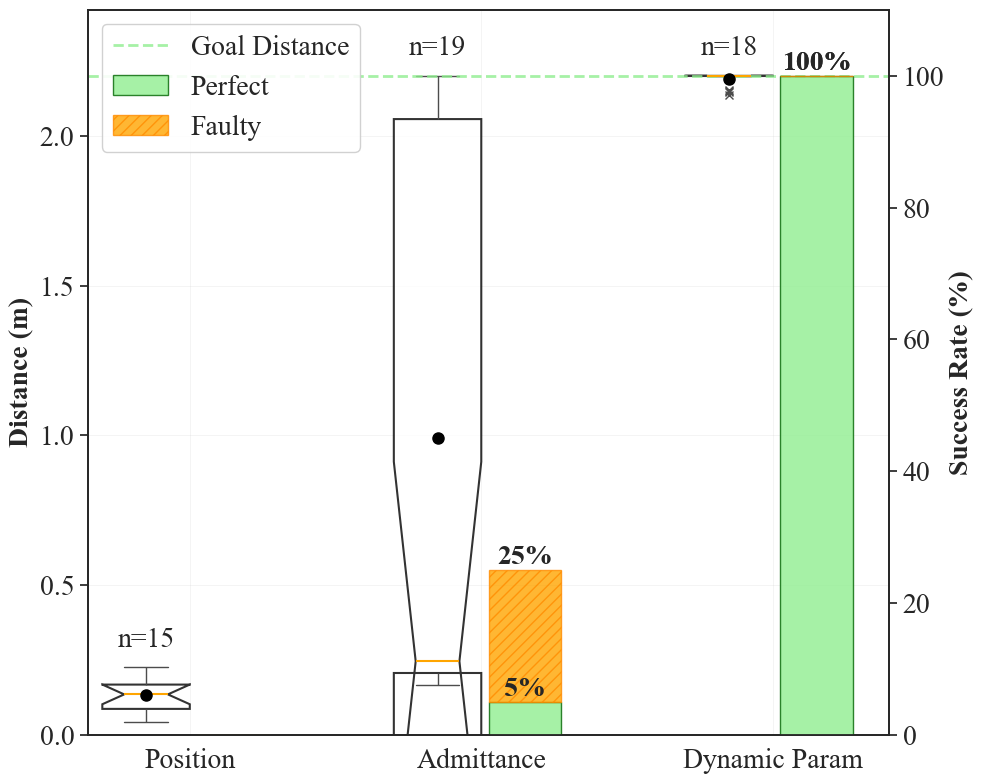

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_distance_box_plot(distance_results, success_rates, fig_size=(18, 6), fontsize=16):
    """
    Create a notched box and whisker plot from distance_results with success rate bars.
   
    Args:
        distance_results: Dictionary from calculate_distance_traveled()
                         {controller: [distances]}
        success_rates: Dictionary with success rates
                      {controller: {'perfect': rate, 'faulty': rate, 'failed': rate}}
        fig_size: Figure size tuple
        fontsize: Font size for labels and text
    """
   
    # Convert distance_results to DataFrame for seaborn
    plot_data = []
    controller_labels = {
        'p': 'Position',
        'a': 'Admittance',
        'dp': 'Dynamic Param'
    }
   
    for controller, distances in distance_results.items():
        for distance in distances:
            plot_data.append({
                'experiment_type': controller_labels.get(controller, controller),
                'distance_traveled': distance
            })
   
    distance_df = pd.DataFrame(plot_data)
    controller_types = list(distance_df['experiment_type'].unique())
   
    # Find the maximum distance across all data
    max_distance = distance_df['distance_traveled'].max()
   
    # Create the plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=fig_size)
    ax2 = ax1.twinx()
   
    sns.set_theme(
        style='white',
        font="Times New Roman"
    )
   
    # Create box plot on primary axis
    sns.boxplot(
        data=distance_df,
        x="experiment_type",
        y="distance_traveled",
        width=0.3,
        positions=[x - 0.15 for x in range(len(controller_types))],
        notch=True,
        showcaps=True,
        showmeans=True,
        flierprops={"marker": "x"},
        medianprops={
            "color": "orange",
            "linewidth": 1.5
        },
        boxprops={
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 1.5,
            "alpha": 0.8
        },
        meanprops={
            "marker": "o",
            "markerfacecolor": "black",
            "markeredgecolor": "black",
            "markersize": 8
        },
        ax=ax1
    )
    
    # Add horizontal line at maximum distance
    ax1.axhline(y=max_distance, color='lightgreen', linestyle='--', linewidth=2, 
               label='Goal Distance', alpha=0.8)
    
    # Set up primary y-axis
    ax1.set_xlabel("", fontsize=fontsize, fontweight='semibold')
    ax1.set_ylabel("Distance (m)", fontsize=fontsize, fontweight='semibold')
    ax1.tick_params(axis='both', labelsize=fontsize)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
   
    # Create stacked bar plot on secondary axis
    x_positions = range(len(controller_types))
    
    # Prepare data for stacked bars
    perfect_rates = []
    faulty_rates = []
    
    for i, controller_type in enumerate(controller_types):
        # Find original controller key
        controller_key = None
        for key, label in controller_labels.items():
            if label == controller_type:
                controller_key = key
                break
        
        if controller_key and controller_key in success_rates:
            rates = success_rates[controller_key]
            perfect_rates.append(rates['perfect'] * 100)
            faulty_rates.append(rates['faulty'] * 100)
        else:
            perfect_rates.append(0)
            faulty_rates.append(0)
    
    # Offset bars to be next to boxes (slightly to the right)
    bar_width = 0.25
    bar_positions = [x + 0.15 for x in x_positions]
    
    # Create stacked bars with different colors and patterns
    bars1 = ax2.bar(bar_positions, perfect_rates, bar_width, 
                   label='Perfect', color='lightgreen', edgecolor='darkgreen', 
                   linewidth=1, alpha=0.8)
    bars2 = ax2.bar(bar_positions, faulty_rates, bar_width, 
                   bottom=perfect_rates, label='Faulty', color='orange', 
                   edgecolor='darkorange', linewidth=1, alpha=0.8, hatch='///')
    
    # Add text labels above bars
    for i, (perfect_rate, faulty_rate) in enumerate(zip(perfect_rates, faulty_rates)):
        x_pos = bar_positions[i]  # Use the same x position as the bars
        
        # Text above perfect bar (green section)
        if perfect_rate > 0:  # Only show if there's a perfect rate
            ax2.text(x_pos, perfect_rate + 0, f'{perfect_rate:.0f}%', 
                    ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
        
        # Text above faulty bar (orange section) - shows combined perfect + faulty rate
        combined_rate = perfect_rate + faulty_rate
        if combined_rate > 0:  # Only show if there's a combined rate
            ax2.text(x_pos, combined_rate + 0, f'{combined_rate:.0f}%', 
                    ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
    
    # Set up secondary y-axis (aligned with primary axis)
    ax2.set_ylabel("Success Rate (%)", fontsize=fontsize, fontweight='semibold')
    ax2.tick_params(axis='y', labelsize=fontsize)
    
    # Align the two y-axes so 0 matches 0% and max_distance matches 100%
    ax1_min, ax1_max = ax1.get_ylim()
    ax1.set_ylim(0, max_distance * 1.1)  # Add some padding
    
    # Set the secondary axis to scale proportionally
    # 100% should align with max_distance on the primary axis
    ax2.set_ylim(0, 100 * (max_distance * 1.1) / max_distance)  # Scale to match primary axis range
    
    # Add sample size annotations above each box
    for i, controller_type in enumerate(controller_types):
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        n = len(subset)
       
        # Get the maximum y-value for this box (top of upper whisker or outliers)
        box_data = subset['distance_traveled'].values
        upper_whisker = box_data.max()
       
        # Place text slightly above the upper whisker
        y_min, y_max = ax1.get_ylim()
        ax1.text(i - 0.15, upper_whisker + (y_max - y_min) * 0.02, f'n={n}', 
                 ha='center', va='bottom', fontsize=fontsize, fontweight='normal')
    
    # Create legend in top left
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
              fontsize=fontsize, framealpha=0.9)
       
    # Save as png and eps
    plt.savefig(f"./figures/{dataset_name}/distance_box_plot.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"./figures/{dataset_name}/distance_box_plot.eps", bbox_inches='tight')
    
    # Print box plot statistics
    print("Box plot statistics:")
    print(f"Maximum distance (Goal): {max_distance:.2f}m")
    for controller_type in controller_types:
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        print(f"{controller_type}:")
        print(f"  Mean: {subset['distance_traveled'].mean():.2f}")
        print(f"  Median: {subset['distance_traveled'].median():.2f}")
        print(f"  Std Dev: {subset['distance_traveled'].std():.2f}")
    
    # Print success rate statistics
    print("\nSuccess rate statistics:")
    for controller_type in controller_types:
        # Find original controller key
        controller_key = None
        for key, label in controller_labels.items():
            if label == controller_type:
                controller_key = key
                break
        
        if controller_key and controller_key in success_rates:
            rates = success_rates[controller_key]
            print(f"{controller_type}:")
            print(f"  Perfect: {rates['perfect']*100:.1f}%")
            print(f"  Faulty: {rates['faulty']*100:.1f}%")
            print(f"  Failed: {rates['failed']*100:.1f}%")
    
    plt.tight_layout()
    plt.show()

# Call the function
create_distance_box_plot(distance_results=distance_results, success_rates=success_rates, fig_size=(10, 8), fontsize=20)

### Distance Traveled / Success Rate Violin Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Violin plot statistics:
Maximum distance (Goal): 2.20m
Position:
  Mean: 0.13
  Median: 0.13
  Std Dev: 0.06
Admittance:
  Mean: 0.99
  Median: 0.25
  Std Dev: 0.95
Dynamic Param:
  Mean: 2.19
  Median: 2.20
  Std Dev: 0.02

Success rate statistics:
Position:
  Perfect: 0.0%
  Faulty: 0.0%
  Failed: 100.0%
Admittance:
  Perfect: 5.0%
  Faulty: 20.0%
  Failed: 75.0%
Dynamic Param:
  Perfect: 100.0%
  Faulty: 0.0%
  Failed: 0.0%


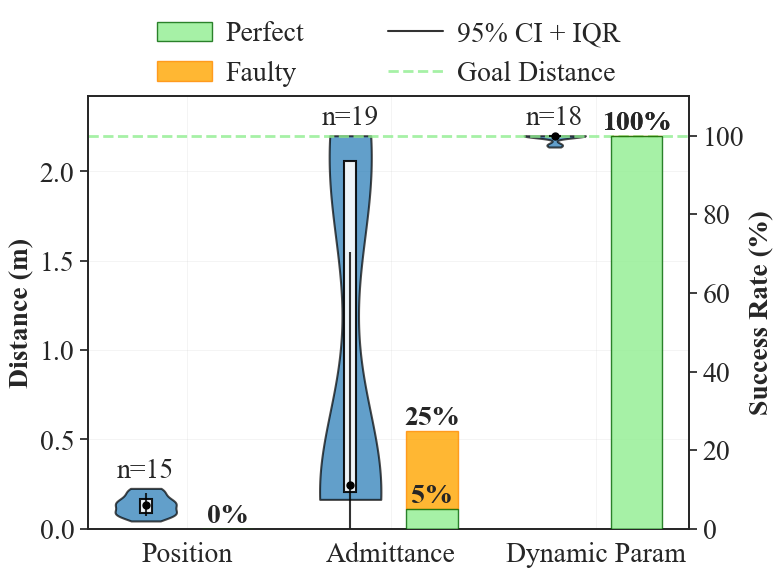

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def adjacent_values(vals, q1, q3):
    """Calculate whisker positions for violin plot"""
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def create_distance_violin_plot(distance_results, success_rates, fig_size=(18, 6), fontsize=16):
    """
    Create a violin plot from distance_results with success rate bars.
   
    Args:
        distance_results: Dictionary from calculate_distance_traveled()
                         {controller: [distances]}
        success_rates: Dictionary with success rates
                      {controller: {'perfect': rate, 'faulty': rate, 'failed': rate}}
        fig_size: Figure size tuple
        fontsize: Font size for labels and text
    """
   
    # Convert distance_results to DataFrame for plotting
    plot_data = []
    controller_labels = {
        'p': 'Position',
        'a': 'Admittance',
        'dp': 'Dynamic Param'
    }
   
    for controller, distances in distance_results.items():
        for distance in distances:
            plot_data.append({
                'experiment_type': controller_labels.get(controller, controller),
                'distance_traveled': distance
            })
   
    distance_df = pd.DataFrame(plot_data)
    controller_types = list(distance_df['experiment_type'].unique())
   
    # Find the maximum distance across all data
    max_distance = distance_df['distance_traveled'].max()
   
    # Create the plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=fig_size)
    ax2 = ax1.twinx()
   
    sns.set_theme(
        style='white',
        font="Times New Roman"
    )

    # Violin and bar x axis offset
    bar_offset = 0.2

    # Prepare data for violin plot
    violin_data = []
    for controller_type in controller_types:
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        violin_data.append(subset['distance_traveled'].values)
    
    # Create violin plot on primary axis with custom bandwidth
    violin_positions = [x - bar_offset for x in range(len(controller_types))]
    parts = ax1.violinplot(
        violin_data, 
        positions=violin_positions,
        showmeans=False, 
        showmedians=False,
        showextrema=False,
        widths=0.3,
        bw_method=0.5  # Try different values: 0.1 (sharper), 0.5 (smoother)
    )
    
    # Style all violin bodies with the same blue color
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor('#1f77b4')  # Blue color for all violins
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
        pc.set_linewidth(1.5)
    
    # Calculate statistics for each violin individually
    quartile1 = []
    medians = []
    quartile3 = []
    means = []
    conf_intervals_95 = []
    
    for data in violin_data:
        data_sorted = np.sort(data)
        q1, median, q3 = np.percentile(data_sorted, [25, 50, 75])
        mean_val = np.mean(data_sorted)
        
        # Calculate 95% confidence interval for the median (notch equivalent)
        n = len(data_sorted)
        # Standard error for median
        se_median = 1.57 * (q3 - q1) / np.sqrt(n)  # Approximation for median SE
        ci_95_lower = median - 1.96 * se_median
        ci_95_upper = median + 1.96 * se_median
        
        quartile1.append(q1)
        medians.append(median)
        quartile3.append(q3)
        means.append(mean_val)
        conf_intervals_95.append([ci_95_lower, ci_95_upper])
    
    # Convert to arrays for easier handling
    quartile1 = np.array(quartile1)
    medians = np.array(medians)
    quartile3 = np.array(quartile3)
    means = np.array(means)
    conf_intervals_95 = np.array(conf_intervals_95)
    
    # Add statistical overlays to violin plots
    box_width = 0.06  # Width of the IQR rectangle
    
    for i, pos in enumerate(violin_positions):
        # Draw 95% CI lines (extending from CI lower to CI upper)
        ci_95_upper_capped = min(conf_intervals_95[i, 1], max_distance)
        ax1.vlines(pos, conf_intervals_95[i, 0], ci_95_upper_capped, 
                   color='black', linestyle='-', lw=1.5, alpha=0.8, zorder=5)
        
        # Draw IQR rectangle (box from Q1 to Q3)
        rect_height = quartile3[i] - quartile1[i]
        rect = plt.Rectangle((pos - box_width/2, quartile1[i]), 
                           box_width, rect_height,
                           facecolor='white', edgecolor='black', 
                           linewidth=1.5, alpha=0.9, zorder=4)
        ax1.add_patch(rect)
        
        # Draw median dot
        ax1.scatter(pos, medians[i], marker='o', color='black', s=25, zorder=5, 
                   edgecolor='black', linewidth=1)
    
    # Add a legend entry for the 95% CI
    ax1.plot([], [], color='black', linestyle='-', linewidth=1.5, 
             label='95% CI + IQR', alpha=0.8)
    
    # Add horizontal line at maximum distance
    ax1.axhline(y=max_distance, color='lightgreen', linestyle='--', linewidth=2, 
               label='Goal Distance', alpha=0.8)
    
    # Set up primary y-axis
    ax1.set_xlabel("", fontsize=fontsize, fontweight='semibold')
    ax1.set_ylabel("Distance (m)", fontsize=fontsize, fontweight='semibold')
    ax1.tick_params(axis='both', labelsize=fontsize)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax1.set_xticks(range(len(controller_types)))
    ax1.set_xticklabels(controller_types)
   
    # Create stacked bar plot on secondary axis
    x_positions = range(len(controller_types))
    
    # Prepare data for stacked bars
    perfect_rates = []
    faulty_rates = []
    
    for i, controller_type in enumerate(controller_types):
        # Find original controller key
        controller_key = None
        for key, label in controller_labels.items():
            if label == controller_type:
                controller_key = key
                break
        
        if controller_key and controller_key in success_rates:
            rates = success_rates[controller_key]
            perfect_rates.append(rates['perfect'] * 100)
            faulty_rates.append(rates['faulty'] * 100)
        else:
            perfect_rates.append(0)
            faulty_rates.append(0)
    
    # Offset bars to be next to violins (slightly to the right)
    bar_width = 0.25
    bar_positions = [x + bar_offset for x in x_positions]
    
    # Create stacked bars with different colors and patterns
    bars1 = ax2.bar(bar_positions, perfect_rates, bar_width, 
                   label='Perfect', color='lightgreen', edgecolor='darkgreen', 
                   linewidth=1, alpha=0.8, zorder=3)
    bars2 = ax2.bar(bar_positions, faulty_rates, bar_width, 
                   bottom=perfect_rates, label='Faulty', color='orange', 
                   edgecolor='darkorange', linewidth=1, alpha=0.8, zorder=2)
    
    # Add text labels above bars
    for i, (perfect_rate, faulty_rate) in enumerate(zip(perfect_rates, faulty_rates)):
        x_pos = bar_positions[i]
        
        # Text above perfect bar (green section)
        ax2.text(x_pos, perfect_rate + 0, f'{perfect_rate:.0f}%', 
                ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
        
        # Text above faulty bar (orange section) - shows combined perfect + faulty rate
        combined_rate = perfect_rate + faulty_rate
        if combined_rate > 0:
            ax2.text(x_pos, combined_rate + 0, f'{combined_rate:.0f}%', 
                    ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
    
    # Set up secondary y-axis (aligned with primary axis)
    ax2.set_ylabel("Success Rate (%)", fontsize=fontsize, fontweight='semibold')
    ax2.tick_params(axis='y', labelsize=fontsize)
    
    # Align the two y-axes so 0 matches 0% and max_distance matches 100%
    ax1_min, ax1_max = ax1.get_ylim()
    ax1.set_ylim(0, max_distance * 1.1)  # Add some padding
    
    # Set the secondary axis to scale proportionally
    ax2.set_ylim(0, 100 * (max_distance * 1.1) / max_distance)
    
    # Add sample size annotations above each violin
    for i, controller_type in enumerate(controller_types):
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        n = len(subset)
       
        # Get the maximum y-value for this violin
        violin_data_subset = subset['distance_traveled'].values
        upper_whisker = violin_data_subset.max()
       
        # Place text slightly above the upper whisker
        y_min, y_max = ax1.get_ylim()
        ax1.text(i - bar_offset, upper_whisker + (y_max - y_min) * 0.01, f'n={n}', 
                 ha='center', va='bottom', fontsize=fontsize, fontweight='normal')
    
    # Create legend above the plot with custom ordering
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Organize legend items: Perfect & Faulty in first row, others in second row
    # Reorder to group success rates together
    all_lines = lines1 + lines2
    all_labels = labels1 + labels2

    # Find indices of Perfect and Faulty (they should be the last two items from ax2)
    perfect_idx = None
    faulty_idx = None
    other_lines = []
    other_labels = []

    for i, label in enumerate(all_labels):
        if label == 'Perfect':
            perfect_idx = i
        elif label == 'Faulty':
            faulty_idx = i
        else:
            other_lines.append(all_lines[i])
            other_labels.append(all_labels[i])

    # Create ordered legend: [Perfect, Faulty, Others...]
    ordered_lines = []
    ordered_labels = []

    if perfect_idx is not None and faulty_idx is not None:
        ordered_lines = [all_lines[perfect_idx], all_lines[faulty_idx]] + other_lines
        ordered_labels = ['Perfect', 'Faulty'] + other_labels
    else:
        ordered_lines = all_lines
        ordered_labels = all_labels

    # Create legend above the plot spanning full width
    legend = ax1.legend(ordered_lines, ordered_labels,
                       loc='upper center',           # Center horizontally
                       bbox_to_anchor=(0.5, 1.2),  # Moved higher to avoid collision
                       ncol=2,                      # 2 columns = 2 rows when items > 2
                       fontsize=fontsize,
                       framealpha=0.0,              # Transparent background
                       frameon=False,               # No frame for cleaner look
                       columnspacing=3.0,           # Space between columns
                       handlelength=2.0,            # Length of legend markers
                       handletextpad=0.5,           # Space between marker and text
                       borderaxespad=0)             # No padding from axes border
       
    # Save as png and eps
    plt.savefig(f"./figures/{dataset_name}/distance_success_combined_plot.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"./figures/{dataset_name}/distance_success_combined_plot.eps", bbox_inches='tight')

    # Print violin plot statistics
    print("Violin plot statistics:")
    print(f"Maximum distance (Goal): {max_distance:.2f}m")
    for controller_type in controller_types:
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        print(f"{controller_type}:")
        print(f"  Mean: {subset['distance_traveled'].mean():.2f}")
        print(f"  Median: {subset['distance_traveled'].median():.2f}")
        print(f"  Std Dev: {subset['distance_traveled'].std():.2f}")
    
    # Print success rate statistics
    print("\nSuccess rate statistics:")
    for controller_type in controller_types:
        # Find original controller key
        controller_key = None
        for key, label in controller_labels.items():
            if label == controller_type:
                controller_key = key
                break
        
        if controller_key and controller_key in success_rates:
            rates = success_rates[controller_key]
            print(f"{controller_type}:")
            print(f"  Perfect: {rates['perfect']*100:.1f}%")
            print(f"  Faulty: {rates['faulty']*100:.1f}%")
            print(f"  Failed: {rates['failed']*100:.1f}%")
    
    plt.tight_layout()
    plt.show()

# Call the function (replace your original function call with this)
create_distance_violin_plot(distance_results=distance_results, success_rates=success_rates, fig_size=(8, 6), fontsize=20)

### Distance Traveled / Success Rate Violin Plot (Seperate)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


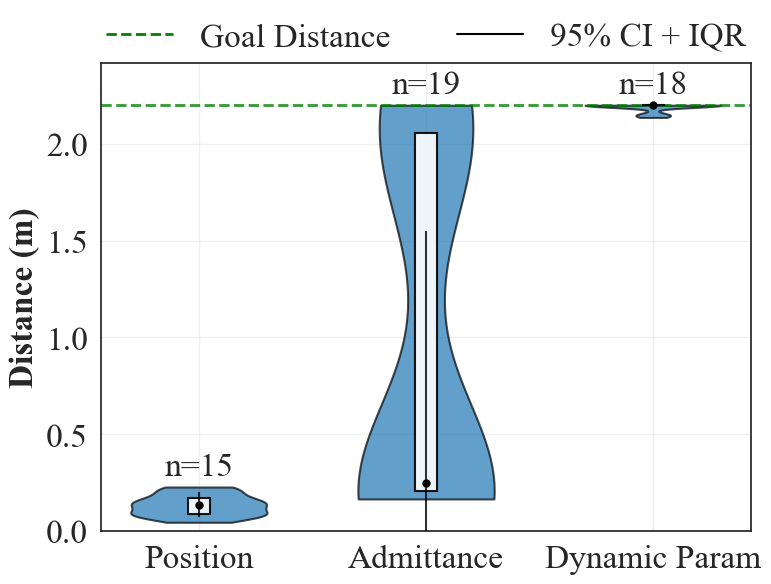

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


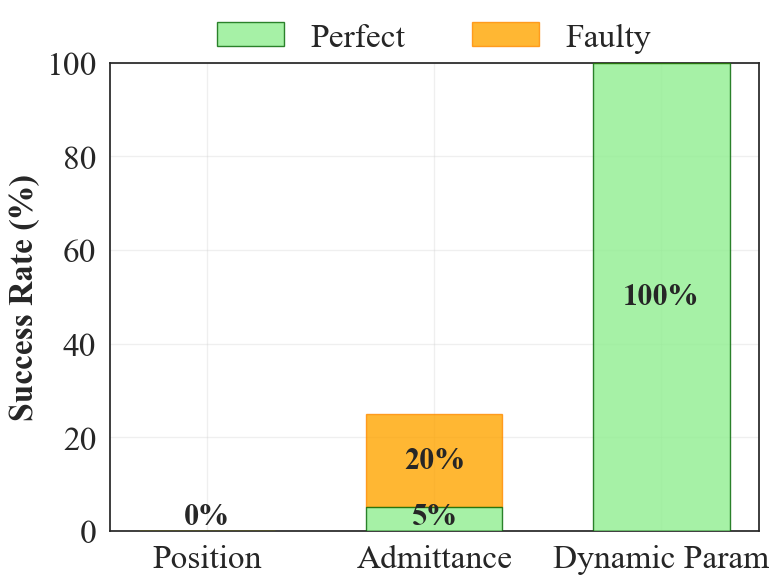

Distance statistics:
Goal distance: 2.20m
Position: Mean=0.13m, Median=0.13m
Admittance: Mean=0.99m, Median=0.25m
Dynamic Param: Mean=2.19m, Median=2.20m

Success rate statistics:
Position: Perfect=0.0%, Faulty=0.0%
Admittance: Perfect=5.0%, Faulty=20.0%
Dynamic Param: Perfect=100.0%, Faulty=0.0%


In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_separate_plots(distance_results, success_rates, fig_size=(8, 6), fontsize=16):
    """
    Create violin plot and success rate bar plot as separate figures.
   
    Args:
        distance_results: Dictionary {controller: [distances]}
        success_rates: Dictionary {controller: {'perfect': rate, 'faulty': rate, 'failed': rate}}
        fig_size: Figure size tuple
        fontsize: Font size for labels and text
    """
    
    # Convert distance_results to DataFrame
    plot_data = []
    controller_labels = {
        'p': 'Position',
        'a': 'Admittance',
        'dp': 'Dynamic Param'
    }
   
    for controller, distances in distance_results.items():
        for distance in distances:
            plot_data.append({
                'experiment_type': controller_labels.get(controller, controller),
                'distance_traveled': distance
            })
   
    distance_df = pd.DataFrame(plot_data)
    controller_types = list(distance_df['experiment_type'].unique())
    max_distance = distance_df['distance_traveled'].max()
    
    # Set style
    sns.set_theme(style='white', font="Times New Roman")
    
    # ============ VIOLIN PLOT FIGURE ============
    fig1, ax1 = plt.subplots(figsize=fig_size)
    
    # Prepare data for violin plot
    violin_data = []
    for controller_type in controller_types:
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        violin_data.append(subset['distance_traveled'].values)
    
    # Create violin plot
    parts = ax1.violinplot(
        violin_data, 
        positions=range(len(controller_types)),
        showmeans=False, 
        showmedians=False,
        showextrema=False,
        widths=0.6,
        bw_method=0.5
    )
    
    # Style violin bodies
    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b4')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
        pc.set_linewidth(1.5)
    
    # Calculate and add statistics overlays
    for i, data in enumerate(violin_data):
        data_sorted = np.sort(data)
        q1, median, q3 = np.percentile(data_sorted, [25, 50, 75])
        
        # 95% confidence interval for median
        n = len(data_sorted)
        se_median = 1.57 * (q3 - q1) / np.sqrt(n)
        ci_95_lower = median - 1.96 * se_median
        ci_95_upper = median + 1.96 * se_median
        
        # Draw 95% CI lines (capped at max distance)
        ci_95_upper_capped = min(ci_95_upper, max_distance)
        ax1.vlines(i, ci_95_lower, ci_95_upper_capped, 
                color='black', linestyle='-', lw=1.5, alpha=0.8, zorder=5)

        # Draw IQR rectangle
        box_width = 0.1
        rect = plt.Rectangle((i - box_width/2, q1), box_width, q3 - q1,
                           facecolor='white', edgecolor='black', 
                           linewidth=1.5, alpha=0.9, zorder=4)
        ax1.add_patch(rect)
        
        # Draw median dot
        ax1.scatter(i, median, marker='o', color='black', s=25, zorder=5)
        
        # Add sample size
        n = len(data)
        y_min, y_max = 0, max_distance * 1.1
        ax1.text(i, data.max() + (y_max - y_min) * 0.01, f'n={n}', 
                 ha='center', va='bottom', fontsize=fontsize)
    
    # Add goal distance line
    ax1.axhline(y=max_distance, color='green', linestyle='--', linewidth=2, alpha=0.8)
    
    # Style violin plot
    ax1.set_ylabel("Distance (m)", fontsize=fontsize, fontweight='semibold')
    ax1.tick_params(axis='both', labelsize=fontsize)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(len(controller_types)))
    ax1.set_xticklabels(controller_types)
    ax1.set_ylim(0, max_distance * 1.1)
    
    # Add legend for violin plot
    violin_legend_handles = [
        plt.Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Goal Distance'),
        plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='95% CI + IQR')
    ]
    
    ax1.legend(handles=violin_legend_handles,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.15),
               ncol=2,
               fontsize=fontsize,
               frameon=False)
    
    plt.tight_layout()
    
    # Save violin plot
    plt.savefig(f"./figures/{dataset_name}/distance_violin_plot.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"./figures/{dataset_name}/distance_violin_plot.eps", bbox_inches='tight')
    plt.show()
    
    # ============ SUCCESS RATE PLOT FIGURE ============
    fig2, ax2 = plt.subplots(figsize=fig_size)
    
    # Prepare success rate data
    perfect_rates = []
    faulty_rates = []
    
    for controller_type in controller_types:
        controller_key = None
        for key, label in controller_labels.items():
            if label == controller_type:
                controller_key = key
                break
        
        if controller_key and controller_key in success_rates:
            rates = success_rates[controller_key]
            perfect_rates.append(rates['perfect'] * 100)
            faulty_rates.append(rates['faulty'] * 100)
        else:
            perfect_rates.append(0)
            faulty_rates.append(0)
    
    # Create stacked bars
    x_positions = range(len(controller_types))
    bar_width = 0.6
    
    bars1 = ax2.bar(x_positions, perfect_rates, bar_width, 
                   label='Perfect', color='lightgreen', edgecolor='darkgreen', 
                   linewidth=1, alpha=0.8, zorder=5)
    bars2 = ax2.bar(x_positions, faulty_rates, bar_width, 
                   bottom=perfect_rates, label='Faulty', color='orange', 
                   edgecolor='darkorange', linewidth=1, alpha=0.8, zorder=4)

    # Add percentage labels on bars
    for i, (perfect_rate, faulty_rate) in enumerate(zip(perfect_rates, faulty_rates)):
        # Always show perfect rate
        ax2.text(i, max(perfect_rate/2, 3), f'{perfect_rate:.0f}%', 
                ha='center', va='center', fontsize=fontsize-2, fontweight='bold', zorder=6)
        
        if faulty_rate > 0:
            ax2.text(i, perfect_rate + faulty_rate/2, f'{faulty_rate:.0f}%', 
                    ha='center', va='center', fontsize=fontsize-2, fontweight='bold', zorder=6)

    # Style success rate plot
    ax2.set_ylabel("Success Rate (%)", fontsize=fontsize, fontweight='semibold')
    ax2.tick_params(axis='both', labelsize=fontsize)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(len(controller_types)))
    ax2.set_xticklabels(controller_types)
    ax2.set_ylim(0, 100)
    
    # Add legend for success rate plot
    ax2.legend(handles=[bars1, bars2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.15),
               ncol=2,
               fontsize=fontsize,
               frameon=False)
    
    plt.tight_layout()
    
    # Save success rate plot
    plt.savefig(f"./figures/{dataset_name}/success_rate_plot.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"./figures/{dataset_name}/success_rate_plot.eps", bbox_inches='tight')
    plt.show()
    
    # ============ PRINT STATISTICS ============
    print("Distance statistics:")
    print(f"Goal distance: {max_distance:.2f}m")
    for controller_type in controller_types:
        subset = distance_df[distance_df['experiment_type'] == controller_type]
        print(f"{controller_type}: Mean={subset['distance_traveled'].mean():.2f}m, "
              f"Median={subset['distance_traveled'].median():.2f}m")
    
    print("\nSuccess rate statistics:")
    for i, controller_type in enumerate(controller_types):
        print(f"{controller_type}: Perfect={perfect_rates[i]:.1f}%, Faulty={faulty_rates[i]:.1f}%")

# Call the function
create_separate_plots(distance_results=distance_results, success_rates=success_rates, fig_size=(8, 6), fontsize=24)